## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| batch_norm_gradient_check.py | 배치 정규화를 구현한 신경망의 오차역전파법 방식의 기울기 계산이 정확한지 확인합니다(기울기 확인). |  |  |
| batch_norm_test.py | MNIST 데이터셋 학습에 배치 정규화를 적용해봅니다. | 6.3.2 배치 정규화의 효과 | 212 |
| hyperparameter_optimization.py | 무작위로 추출한 값부터 시작하여 두 하이퍼파라미터(가중치 감소 계수, 학습률)를 최적화해봅니다. | 6.5.3 하이퍼파라미터 최적화 구현하기 | 224 |
| optimizer_compare_mnist.py | SGD, 모멘텀, AdaGrad, Adam의 학습 속도를 비교합니다. | 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교 | 201 |
| optimizer_compare_naive.py | SGD, 모멘텀, AdaGrad, Adam의 학습 패턴을 비교합니다. | 6.1.7 어느 갱신 방법을 이용할 것인가? | 200 |
| overfit_dropout.py | 일부러 오버피팅을 일으킨 후 드롭아웃(dropout)의 효과를 관찰합니다. | 6.4.3 드롭아웃 | 219 |
| overfit_weight_decay.py | 일부러 오버피팅을 일으킨 후 가중치 감소(weight_decay)의 효과를 관찰합니다. | 6.4.1 오버피팅 | 215 |
| weight_init_activation_histogram.py | 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그려봅니다. | 6.2.2 은닉층의 활성화값 분포 | 203 |
| weight_init_compare.py | 가중치 초깃값(std=0.01, He, Xavier)에 따른 학습 속도를 비교합니다. | 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교 | 209 |


# batch_norm_gradient_check.py

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                              use_batchnorm=True)

x_batch = x_train[:1]
t_batch = t_train[:1]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:0.0
b1:0.0
gamma1:0.0
beta1:0.0
W2:0.0
b2:0.0
gamma2:0.0
beta2:0.04636255680514623
W3:0.0
b3:1.7990402263745597e-07


# batch_norm_test.py

============== 1/16 ==============
epoch:0 | 0.094 - 0.086
epoch:1 | 0.097 - 0.113


/Users/csg/HomeWorkspace/git/DL-scratch1/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:2 | 0.097 - 0.126
epoch:3 | 0.097 - 0.149
epoch:4 | 0.097 - 0.168
epoch:5 | 0.097 - 0.199
epoch:6 | 0.097 - 0.218
epoch:7 | 0.097 - 0.237
epoch:8 | 0.097 - 0.255
epoch:9 | 0.097 - 0.273
epoch:10 | 0.097 - 0.276
epoch:11 | 0.097 - 0.287
epoch:12 | 0.097 - 0.316
epoch:13 | 0.097 - 0.326
epoch:14 | 0.097 - 0.338
epoch:15 | 0.097 - 0.352
epoch:16 | 0.097 - 0.371
epoch:17 | 0.097 - 0.373


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.384
epoch:19 | 0.097 - 0.398
============== 2/16 ==============


/Users/csg/HomeWorkspace/git/DL-scratch1/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


epoch:0 | 0.1 - 0.102
epoch:1 | 0.097 - 0.15
epoch:2 | 0.097 - 0.189
epoch:3 | 0.097 - 0.204
epoch:4 | 0.097 - 0.238
epoch:5 | 0.097 - 0.261
epoch:6 | 0.097 - 0.281
epoch:7 | 0.097 - 0.313
epoch:8 | 0.097 - 0.326
epoch:9 | 0.097 - 0.349
epoch:10 | 0.097 - 0.361
epoch:11 | 0.097 - 0.384
epoch:12 | 0.097 - 0.394
epoch:13 | 0.097 - 0.417
epoch:14 | 0.097 - 0.428
epoch:15 | 0.097 - 0.433
epoch:16 | 0.097 - 0.467
epoch:17 | 0.097 - 0.483
epoch:18 | 0.097 - 0.498


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.517
============== 3/16 ==============
epoch:0 | 0.064 - 0.069
epoch:1 | 0.371 - 0.092
epoch:2 | 0.495 - 0.113
epoch:3 | 0.598 - 0.144
epoch:4 | 0.675 - 0.168
epoch:5 | 0.725 - 0.196
epoch:6 | 0.788 - 0.221
epoch:7 | 0.815 - 0.262
epoch:8 | 0.861 - 0.311
epoch:9 | 0.88 - 0.333
epoch:10 | 0.911 - 0.369
epoch:11 | 0.927 - 0.406
epoch:12 | 0.934 - 0.432
epoch:13 | 0.944 - 0.466
epoch:14 | 0.955 - 0.495
epoch:15 | 0.958 - 0.513
epoch:16 | 0.97 - 0.546
epoch:17 | 0.976 - 0.563
epoch:18 | 0.979 - 0.596


No handles with labels found to put in legend.


epoch:19 | 0.98 - 0.609
============== 4/16 ==============
epoch:0 | 0.103 - 0.096
epoch:1 | 0.22 - 0.095
epoch:2 | 0.332 - 0.183
epoch:3 | 0.443 - 0.261
epoch:4 | 0.525 - 0.338
epoch:5 | 0.607 - 0.399
epoch:6 | 0.64 - 0.456
epoch:7 | 0.676 - 0.5
epoch:8 | 0.71 - 0.555
epoch:9 | 0.74 - 0.607
epoch:10 | 0.756 - 0.642
epoch:11 | 0.771 - 0.661
epoch:12 | 0.79 - 0.694
epoch:13 | 0.81 - 0.718
epoch:14 | 0.826 - 0.735
epoch:15 | 0.832 - 0.754
epoch:16 | 0.844 - 0.77
epoch:17 | 0.854 - 0.776
epoch:18 | 0.861 - 0.797


No handles with labels found to put in legend.


epoch:19 | 0.873 - 0.817
============== 5/16 ==============
epoch:0 | 0.094 - 0.091
epoch:1 | 0.103 - 0.119
epoch:2 | 0.108 - 0.232
epoch:3 | 0.118 - 0.399
epoch:4 | 0.13 - 0.508
epoch:5 | 0.129 - 0.593
epoch:6 | 0.142 - 0.65
epoch:7 | 0.149 - 0.7
epoch:8 | 0.152 - 0.727
epoch:9 | 0.169 - 0.752
epoch:10 | 0.183 - 0.773
epoch:11 | 0.2 - 0.79
epoch:12 | 0.222 - 0.806
epoch:13 | 0.233 - 0.821
epoch:14 | 0.25 - 0.831
epoch:15 | 0.262 - 0.837
epoch:16 | 0.273 - 0.85
epoch:17 | 0.266 - 0.849
epoch:18 | 0.277 - 0.867


No handles with labels found to put in legend.


epoch:19 | 0.284 - 0.886
============== 6/16 ==============
epoch:0 | 0.12 - 0.092
epoch:1 | 0.116 - 0.222
epoch:2 | 0.116 - 0.49
epoch:3 | 0.116 - 0.663
epoch:4 | 0.116 - 0.731
epoch:5 | 0.116 - 0.766
epoch:6 | 0.115 - 0.792
epoch:7 | 0.078 - 0.808
epoch:8 | 0.085 - 0.824
epoch:9 | 0.081 - 0.843
epoch:10 | 0.105 - 0.857
epoch:11 | 0.103 - 0.865
epoch:12 | 0.081 - 0.88
epoch:13 | 0.117 - 0.895
epoch:14 | 0.117 - 0.908
epoch:15 | 0.117 - 0.92
epoch:16 | 0.117 - 0.926
epoch:17 | 0.117 - 0.935
epoch:18 | 0.117 - 0.944


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.951
============== 7/16 ==============
epoch:0 | 0.103 - 0.106
epoch:1 | 0.116 - 0.225
epoch:2 | 0.117 - 0.535
epoch:3 | 0.117 - 0.663
epoch:4 | 0.117 - 0.726
epoch:5 | 0.117 - 0.775
epoch:6 | 0.117 - 0.808
epoch:7 | 0.116 - 0.845
epoch:8 | 0.116 - 0.877
epoch:9 | 0.116 - 0.899
epoch:10 | 0.116 - 0.926
epoch:11 | 0.117 - 0.946
epoch:12 | 0.116 - 0.955
epoch:13 | 0.116 - 0.962
epoch:14 | 0.116 - 0.973
epoch:15 | 0.116 - 0.977
epoch:16 | 0.116 - 0.982
epoch:17 | 0.116 - 0.986
epoch:18 | 0.116 - 0.988


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.996
============== 8/16 ==============
epoch:0 | 0.117 - 0.095
epoch:1 | 0.117 - 0.429
epoch:2 | 0.117 - 0.642
epoch:3 | 0.117 - 0.714
epoch:4 | 0.116 - 0.776
epoch:5 | 0.117 - 0.805
epoch:6 | 0.117 - 0.83
epoch:7 | 0.117 - 0.871
epoch:8 | 0.117 - 0.919
epoch:9 | 0.117 - 0.937
epoch:10 | 0.117 - 0.964
epoch:11 | 0.117 - 0.978
epoch:12 | 0.117 - 0.99
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.994
epoch:15 | 0.116 - 0.998
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 9/16 ==============
epoch:0 | 0.099 - 0.124
epoch:1 | 0.117 - 0.486
epoch:2 | 0.116 - 0.723
epoch:3 | 0.116 - 0.806
epoch:4 | 0.117 - 0.857
epoch:5 | 0.116 - 0.904
epoch:6 | 0.116 - 0.936
epoch:7 | 0.116 - 0.919
epoch:8 | 0.116 - 0.975
epoch:9 | 0.116 - 0.983
epoch:10 | 0.116 - 0.987
epoch:11 | 0.116 - 0.988
epoch:12 | 0.116 - 0.996
epoch:13 | 0.117 - 0.996
epoch:14 | 0.116 - 0.997
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.999
epoch:17 | 0.117 - 0.999
epoch:18 | 0.117 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 10/16 ==============
epoch:0 | 0.093 - 0.158
epoch:1 | 0.105 - 0.562
epoch:2 | 0.117 - 0.859
epoch:3 | 0.117 - 0.916
epoch:4 | 0.117 - 0.921
epoch:5 | 0.117 - 0.96
epoch:6 | 0.117 - 0.958
epoch:7 | 0.117 - 0.977
epoch:8 | 0.117 - 0.967
epoch:9 | 0.117 - 0.985
epoch:10 | 0.117 - 0.989
epoch:11 | 0.117 - 0.982
epoch:12 | 0.117 - 0.994
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.999
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 1.0
epoch:17 | 0.117 - 1.0
epoch:18 | 0.117 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.117 - 1.0
============== 11/16 ==============
epoch:0 | 0.1 - 0.196
epoch:1 | 0.117 - 0.685
epoch:2 | 0.117 - 0.769
epoch:3 | 0.117 - 0.792
epoch:4 | 0.117 - 0.821
epoch:5 | 0.116 - 0.868
epoch:6 | 0.117 - 0.882
epoch:7 | 0.116 - 0.962
epoch:8 | 0.116 - 0.873
epoch:9 | 0.116 - 0.977
epoch:10 | 0.116 - 0.976
epoch:11 | 0.116 - 0.986
epoch:12 | 0.116 - 0.981
epoch:13 | 0.116 - 0.978
epoch:14 | 0.116 - 0.99
epoch:15 | 0.117 - 0.985
epoch:16 | 0.117 - 0.989
epoch:17 | 0.117 - 0.994
epoch:18 | 0.117 - 0.994


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.994
============== 12/16 ==============
epoch:0 | 0.093 - 0.131
epoch:1 | 0.105 - 0.56
epoch:2 | 0.116 - 0.669
epoch:3 | 0.116 - 0.742
epoch:4 | 0.116 - 0.723
epoch:5 | 0.116 - 0.775
epoch:6 | 0.116 - 0.814
epoch:7 | 0.116 - 0.843
epoch:8 | 0.116 - 0.842
epoch:9 | 0.116 - 0.858
epoch:10 | 0.116 - 0.874
epoch:11 | 0.116 - 0.864
epoch:12 | 0.116 - 0.883
epoch:13 | 0.116 - 0.894
epoch:14 | 0.116 - 0.869
epoch:15 | 0.116 - 0.891
epoch:16 | 0.116 - 0.896
epoch:17 | 0.116 - 0.829


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.875
epoch:19 | 0.117 - 0.882
============== 13/16 ==============
epoch:0 | 0.097 - 0.11
epoch:1 | 0.117 - 0.468
epoch:2 | 0.117 - 0.553
epoch:3 | 0.117 - 0.582
epoch:4 | 0.117 - 0.575
epoch:5 | 0.117 - 0.589
epoch:6 | 0.117 - 0.701
epoch:7 | 0.117 - 0.681
epoch:8 | 0.117 - 0.492
epoch:9 | 0.117 - 0.656
epoch:10 | 0.117 - 0.713
epoch:11 | 0.117 - 0.718
epoch:12 | 0.117 - 0.721
epoch:13 | 0.117 - 0.714
epoch:14 | 0.117 - 0.727
epoch:15 | 0.117 - 0.732
epoch:16 | 0.117 - 0.746
epoch:17 | 0.117 - 0.639


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.631
epoch:19 | 0.117 - 0.628
============== 14/16 ==============
epoch:0 | 0.099 - 0.158
epoch:1 | 0.099 - 0.453
epoch:2 | 0.117 - 0.554
epoch:3 | 0.117 - 0.574
epoch:4 | 0.117 - 0.663
epoch:5 | 0.116 - 0.638
epoch:6 | 0.116 - 0.603
epoch:7 | 0.116 - 0.658
epoch:8 | 0.116 - 0.697
epoch:9 | 0.117 - 0.696
epoch:10 | 0.117 - 0.693
epoch:11 | 0.117 - 0.7
epoch:12 | 0.117 - 0.704
epoch:13 | 0.116 - 0.666
epoch:14 | 0.116 - 0.707
epoch:15 | 0.116 - 0.708
epoch:16 | 0.116 - 0.702
epoch:17 | 0.116 - 0.706


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.708
epoch:19 | 0.116 - 0.707
============== 15/16 ==============
epoch:0 | 0.094 - 0.169
epoch:1 | 0.117 - 0.379
epoch:2 | 0.097 - 0.414
epoch:3 | 0.117 - 0.482
epoch:4 | 0.117 - 0.476
epoch:5 | 0.117 - 0.492
epoch:6 | 0.117 - 0.468
epoch:7 | 0.117 - 0.509
epoch:8 | 0.117 - 0.515
epoch:9 | 0.117 - 0.522
epoch:10 | 0.117 - 0.5
epoch:11 | 0.117 - 0.522
epoch:12 | 0.117 - 0.522
epoch:13 | 0.117 - 0.518
epoch:14 | 0.117 - 0.512
epoch:15 | 0.117 - 0.506
epoch:16 | 0.117 - 0.518
epoch:17 | 0.117 - 0.523
epoch:18 | 0.117 - 0.512


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.524
============== 16/16 ==============
epoch:0 | 0.117 - 0.117
epoch:1 | 0.117 - 0.098
epoch:2 | 0.117 - 0.35
epoch:3 | 0.117 - 0.394
epoch:4 | 0.117 - 0.405
epoch:5 | 0.117 - 0.408
epoch:6 | 0.116 - 0.413
epoch:7 | 0.116 - 0.416
epoch:8 | 0.116 - 0.418
epoch:9 | 0.116 - 0.422
epoch:10 | 0.116 - 0.422
epoch:11 | 0.116 - 0.407
epoch:12 | 0.117 - 0.418
epoch:13 | 0.117 - 0.419
epoch:14 | 0.117 - 0.426
epoch:15 | 0.117 - 0.429
epoch:16 | 0.117 - 0.424
epoch:17 | 0.117 - 0.427
epoch:18 | 0.117 - 0.445
epoch:19 | 0.117 - 0.455


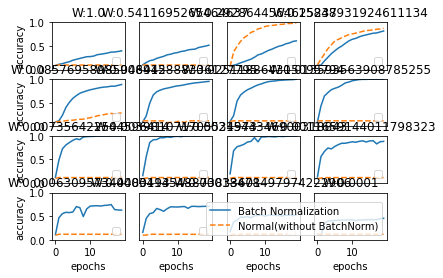

In [19]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

# hyperparameter_optimization.py

val acc:0.11 | lr:1.3965029646514055e-05, weight decay:7.75585527727338e-07
val acc:0.14 | lr:1.2452381986468907e-06, weight decay:1.2887485746952683e-05
val acc:0.44 | lr:0.002489806100729005, weight decay:4.35367117939363e-06
val acc:0.12 | lr:1.3351042509128121e-06, weight decay:2.5852312219716473e-05
val acc:0.29 | lr:0.002262031664509945, weight decay:1.9072540355051282e-05
val acc:0.08 | lr:1.7349670434686175e-06, weight decay:1.6044839731148365e-08
val acc:0.15 | lr:2.5870398496932997e-05, weight decay:5.032205076596564e-06
val acc:0.09 | lr:4.174586194494835e-06, weight decay:2.8794247810810233e-07
val acc:0.1 | lr:6.9566189067380005e-06, weight decay:2.455185572139676e-08
val acc:0.3 | lr:0.0015982940929404204, weight decay:1.060279852849971e-08
val acc:0.52 | lr:0.0027637352842314377, weight decay:5.786420309175179e-06
val acc:0.15 | lr:0.00046504177532423273, weight decay:1.1331953697493442e-05
val acc:0.12 | lr:1.2809486903815942e-06, weight decay:9.275816569014307e-05
val 

Best-13(val acc:0.54) | lr:0.0033956761293330107, weight decay:6.050944181911538e-06
Best-14(val acc:0.52) | lr:0.0027637352842314377, weight decay:5.786420309175179e-06
Best-15(val acc:0.51) | lr:0.0035808426621955197, weight decay:1.0260561354152269e-07
Best-16(val acc:0.51) | lr:0.003523886052380427, weight decay:3.5002281759857834e-07
Best-17(val acc:0.47) | lr:0.002544848943401062, weight decay:4.4823352154937344e-07
Best-18(val acc:0.45) | lr:0.0022029280621400174, weight decay:2.0467386994838313e-06
Best-19(val acc:0.44) | lr:0.002489806100729005, weight decay:4.35367117939363e-06
Best-20(val acc:0.44) | lr:0.0031711694119892666, weight decay:1.058769880552924e-08


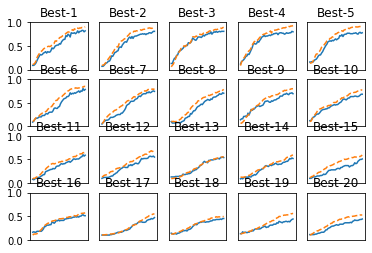

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

# optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.303333937755004
Momentum:2.412218491248149
AdaGrad:2.206138185949219
Adam:2.2847808957654667
===========iteration:100===========
SGD:1.6363429401989715
Momentum:0.34980059632624366
AdaGrad:0.1524974286055544
Adam:0.24824516924210083
===========iteration:200===========
SGD:0.7995251704095906
Momentum:0.24298340622061515
AdaGrad:0.07928608515299851
Adam:0.13847707140527338
===========iteration:300===========
SGD:0.4999152374391961
Momentum:0.15140633250093893
AdaGrad:0.059732841050141164
Adam:0.10701912389335949
===========iteration:400===========
SGD:0.44173436644858916
Momentum:0.21784858887154318
AdaGrad:0.11559980898238759
Adam:0.16413221231098335
===========iteration:500===========
SGD:0.3674602449772225
Momentum:0.1020263490784053
AdaGrad:0.08197778080540383
Adam:0.1351691220995222
===========iteration:600===========
SGD:0.3782170129203251
Momentum:0.11341281923431142
AdaGrad:0.05832858699114865
Adam:0.08539012675737223
===========iteration:7

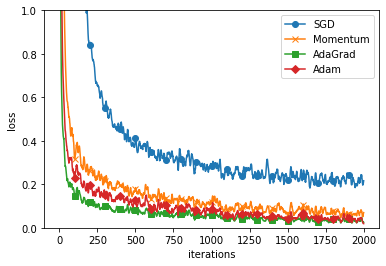

In [12]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

# optimizer_compare_naive.py

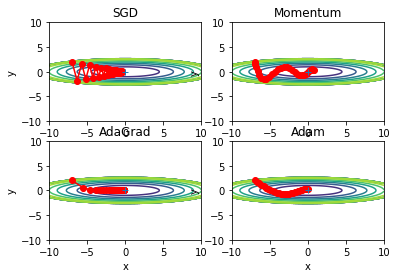

In [13]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

# overfit_dropout.py

train loss:2.2993377437504807
=== epoch:1, train acc:0.12333333333333334, test acc:0.1494 ===
train loss:2.314133106157474
train loss:2.3094932757723483
train loss:2.3103834525712967
=== epoch:2, train acc:0.13, test acc:0.1539 ===
train loss:2.3083999770570958
train loss:2.3076793211171527
train loss:2.320168395948796
=== epoch:3, train acc:0.14, test acc:0.1567 ===
train loss:2.3045159152293935
train loss:2.3092260229706465
train loss:2.3049443972227084
=== epoch:4, train acc:0.13666666666666666, test acc:0.1569 ===
train loss:2.3121604263977567
train loss:2.2918489859235227
train loss:2.297904584483832
=== epoch:5, train acc:0.13333333333333333, test acc:0.1601 ===
train loss:2.30107143861765
train loss:2.311522311275863
train loss:2.293208103144776
=== epoch:6, train acc:0.13, test acc:0.1588 ===
train loss:2.2977068519668546
train loss:2.305350994614582
train loss:2.2846815872945836
=== epoch:7, train acc:0.12666666666666668, test acc:0.1596 ===
train loss:2.279645303003983
train 

train loss:2.2495567312834286
train loss:2.2529273680992437
train loss:2.2402930179986744
=== epoch:57, train acc:0.31333333333333335, test acc:0.2743 ===
train loss:2.2407295896783244
train loss:2.243047908445571
train loss:2.240634852967808
=== epoch:58, train acc:0.31333333333333335, test acc:0.2725 ===
train loss:2.230776392752191
train loss:2.2214131955700758
train loss:2.233154984855754
=== epoch:59, train acc:0.30666666666666664, test acc:0.274 ===
train loss:2.2168800180331836
train loss:2.249029701843521
train loss:2.231492328382444
=== epoch:60, train acc:0.31, test acc:0.2729 ===
train loss:2.241877516286103
train loss:2.211297943217165
train loss:2.2357024427723515
=== epoch:61, train acc:0.30666666666666664, test acc:0.2664 ===
train loss:2.229814082485184
train loss:2.245833243543147
train loss:2.2193340763537277
=== epoch:62, train acc:0.31, test acc:0.2671 ===
train loss:2.227698542041168
train loss:2.2397331731135246
train loss:2.245116351215342
=== epoch:63, train acc

train loss:2.1517764767698795
train loss:2.12707404658279
train loss:2.1488901026825253
=== epoch:112, train acc:0.35, test acc:0.2906 ===
train loss:2.0741221116871724
train loss:2.07033362188259
train loss:2.0874785735529655
=== epoch:113, train acc:0.3333333333333333, test acc:0.286 ===
train loss:2.1316266611556625
train loss:2.1314419727471954
train loss:2.1269262828273434
=== epoch:114, train acc:0.3566666666666667, test acc:0.288 ===
train loss:2.1005993176982773
train loss:2.0581764400578337
train loss:2.0895657379683685
=== epoch:115, train acc:0.35333333333333333, test acc:0.2884 ===
train loss:2.1604169933137767
train loss:2.057553628405621
train loss:2.126077777569001
=== epoch:116, train acc:0.36333333333333334, test acc:0.2938 ===
train loss:2.0725359017271403
train loss:2.12941361360826
train loss:2.0599688029026053
=== epoch:117, train acc:0.36666666666666664, test acc:0.2972 ===
train loss:2.035306137944587
train loss:2.130799848983792
train loss:2.096575780776636
=== 

train loss:1.9209291633466945
train loss:1.966406369414972
train loss:1.7907656748897935
=== epoch:167, train acc:0.43333333333333335, test acc:0.3563 ===
train loss:1.889764613233754
train loss:1.887934360898488
train loss:1.8907258272524348
=== epoch:168, train acc:0.43333333333333335, test acc:0.3558 ===
train loss:1.8499449279346976
train loss:1.8481635252434896
train loss:1.7664164998570273
=== epoch:169, train acc:0.43333333333333335, test acc:0.3563 ===
train loss:1.826468899778959
train loss:1.8100270361613553
train loss:1.948916760392659
=== epoch:170, train acc:0.43333333333333335, test acc:0.3554 ===
train loss:1.89820122199349
train loss:1.8296732726134848
train loss:1.8731993069567203
=== epoch:171, train acc:0.43666666666666665, test acc:0.3581 ===
train loss:1.7850563893095557
train loss:1.9776735404570116
train loss:1.8369915055563724
=== epoch:172, train acc:0.42333333333333334, test acc:0.3523 ===
train loss:1.8741952396769022
train loss:1.8310598163250316
train loss:

train loss:1.6332566936025128
train loss:1.6102473318385493
train loss:1.6217969148532967
=== epoch:221, train acc:0.5366666666666666, test acc:0.424 ===
train loss:1.6040088844464255
train loss:1.4641971113344017
train loss:1.6140010082224523
=== epoch:222, train acc:0.54, test acc:0.4272 ===
train loss:1.5398550313810333
train loss:1.5656249541957634
train loss:1.571522426898589
=== epoch:223, train acc:0.5333333333333333, test acc:0.4242 ===
train loss:1.6737595859465266
train loss:1.6070442251820412
train loss:1.6714981324016733
=== epoch:224, train acc:0.5333333333333333, test acc:0.4319 ===
train loss:1.4942271596180046
train loss:1.4980900318166437
train loss:1.4841324730045906
=== epoch:225, train acc:0.5333333333333333, test acc:0.4266 ===
train loss:1.5045062104232416
train loss:1.5461250107566398
train loss:1.631580883801222
=== epoch:226, train acc:0.5466666666666666, test acc:0.4294 ===
train loss:1.5039542162798687
train loss:1.4335312655960002
train loss:1.51273497455044

train loss:1.424869463933406
train loss:1.2174288295448719
train loss:1.2266361407338706
=== epoch:276, train acc:0.6366666666666667, test acc:0.5028 ===
train loss:1.2164748298262327
train loss:1.0814868782876463
train loss:1.1776123026641436
=== epoch:277, train acc:0.6333333333333333, test acc:0.5012 ===
train loss:1.2494614486272022
train loss:1.104586809044501
train loss:1.2313232499853313
=== epoch:278, train acc:0.64, test acc:0.4981 ===
train loss:1.2692312448151142
train loss:1.1905663210137718
train loss:1.1481317469010262
=== epoch:279, train acc:0.65, test acc:0.4988 ===
train loss:1.182634149627048
train loss:1.3110607345446934
train loss:1.1410875541800656
=== epoch:280, train acc:0.6733333333333333, test acc:0.5072 ===
train loss:1.1642936549532232
train loss:1.2469408202672678
train loss:1.1814187058660002
=== epoch:281, train acc:0.6633333333333333, test acc:0.5062 ===
train loss:1.083947165473388
train loss:1.2713171366523317
train loss:1.2901049183343736
=== epoch:28

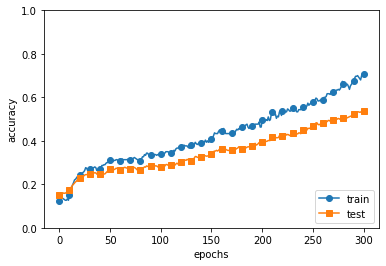

In [14]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# overfit_weight_decay.py

epoch:0, train acc:0.10666666666666667, test acc:0.0997
epoch:1, train acc:0.11, test acc:0.1021
epoch:2, train acc:0.11666666666666667, test acc:0.1043
epoch:3, train acc:0.13, test acc:0.1077
epoch:4, train acc:0.13666666666666666, test acc:0.1134
epoch:5, train acc:0.15666666666666668, test acc:0.1211
epoch:6, train acc:0.16333333333333333, test acc:0.1285
epoch:7, train acc:0.17666666666666667, test acc:0.1366
epoch:8, train acc:0.18666666666666668, test acc:0.1515
epoch:9, train acc:0.20666666666666667, test acc:0.1636
epoch:10, train acc:0.22666666666666666, test acc:0.1785
epoch:11, train acc:0.25333333333333335, test acc:0.1958
epoch:12, train acc:0.27, test acc:0.2119
epoch:13, train acc:0.27666666666666667, test acc:0.2156
epoch:14, train acc:0.27666666666666667, test acc:0.222
epoch:15, train acc:0.28, test acc:0.23
epoch:16, train acc:0.29, test acc:0.24
epoch:17, train acc:0.30333333333333334, test acc:0.2535
epoch:18, train acc:0.31666666666666665, test acc:0.2642
epoch:1

epoch:160, train acc:0.8466666666666667, test acc:0.6989
epoch:161, train acc:0.8533333333333334, test acc:0.6983
epoch:162, train acc:0.8466666666666667, test acc:0.7015
epoch:163, train acc:0.8466666666666667, test acc:0.7015
epoch:164, train acc:0.8366666666666667, test acc:0.6971
epoch:165, train acc:0.8566666666666667, test acc:0.702
epoch:166, train acc:0.8433333333333334, test acc:0.6919
epoch:167, train acc:0.8566666666666667, test acc:0.6974
epoch:168, train acc:0.8533333333333334, test acc:0.6995
epoch:169, train acc:0.85, test acc:0.6993
epoch:170, train acc:0.85, test acc:0.6977
epoch:171, train acc:0.8466666666666667, test acc:0.6957
epoch:172, train acc:0.8633333333333333, test acc:0.6986
epoch:173, train acc:0.8633333333333333, test acc:0.7038
epoch:174, train acc:0.8566666666666667, test acc:0.7021
epoch:175, train acc:0.8466666666666667, test acc:0.6963
epoch:176, train acc:0.8666666666666667, test acc:0.7058
epoch:177, train acc:0.87, test acc:0.7023
epoch:178, train 

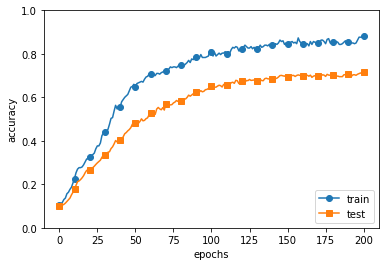

In [15]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# weight_init_activation_histogram.py 

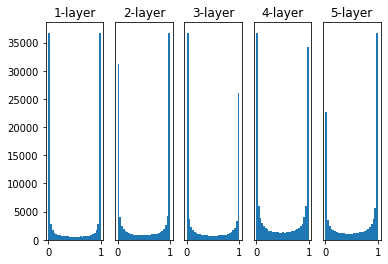

In [16]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [17]:
# weight_init_compare.py

===========iteration:0===========
std=0.01:2.3025498626251166
Xavier:2.2954994593801783
He:2.474056954135901
===========iteration:100===========
std=0.01:2.3026620036748398
Xavier:2.21587545514945
He:1.8901903529704482
===========iteration:200===========
std=0.01:2.3016323627931667
Xavier:2.0348897551636025
He:0.9936356112778696
===========iteration:300===========
std=0.01:2.3034867590801573
Xavier:1.5772951396653507
He:0.4963144300464561
===========iteration:400===========
std=0.01:2.3042168891566046
Xavier:1.0200442855394751
He:0.4150336697460636
===========iteration:500===========
std=0.01:2.2997903117829392
Xavier:0.7829571721420856
He:0.44129588655048596
===========iteration:600===========
std=0.01:2.299326041203668
Xavier:0.5313768292200446
He:0.36629027058576474
===========iteration:700===========
std=0.01:2.3049841777965994
Xavier:0.45895956699737184
He:0.2915133592120988
===========iteration:800===========
std=0.01:2.2994283672017857
Xavier:0.5394195402461186
He:0.383953788174

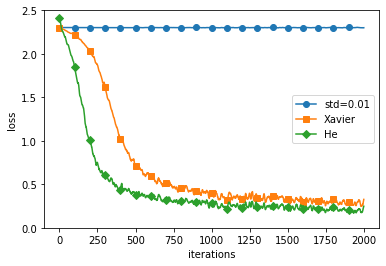

In [18]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()